In [1]:
'''
short summary of the code below:
- it identifies null values and fills them accordingly
- using KNNImputer to fill in the missing values in the numerical characteristics
- The algorithm in ML that can handle missing values

https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide
https://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column

'''

'\nshort summary of the code below:\n- it identifies null values and fills them accordingly\n- using KNNImputer to fill in the missing values in the numerical characteristics\n- The algorithm in ML that can handle missing values\n\nhttps://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide\nhttps://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column\n\n'

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

import time
import warnings

warnings.filterwarnings('ignore')
sns.set_theme()

### Data description
- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### OBJECTIVE
Predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

SOURCE: https://www.kaggle.com/competitions/spaceship-titanic/overview

In [3]:
import os
# prepering directories
path = os.getcwd()
# subfolders
input_dir = os.path.join(path, 'data')
output_dir = os.path.join(path, 'outputs')

# Data Loading and basic exploration

In [4]:
train = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test = pd.read_csv(os.path.join(input_dir, 'test.csv'))

In [5]:
print( 'Number of rows', train.shape[0]  )
print( 'Number of columns', train.shape[1]  )

Number of rows 8693
Number of columns 14


In [6]:
print( 'Number of values per column' )
train.count()

Number of values per column


PassengerId     8693
HomePlanet      8492
CryoSleep       8476
Cabin           8494
Destination     8511
Age             8514
VIP             8490
RoomService     8512
FoodCourt       8510
ShoppingMall    8485
Spa             8510
VRDeck          8505
Name            8493
Transported     8693
dtype: int64

In [7]:
print('Total number of values in data', train.count().sum() )

Total number of values in data 119378


#### Basic data exploration and missing values 

In [8]:
# initializing new data frame that will be displayed in the table
dataset = train.copy()
data_review = pd.DataFrame(columns = ['Column','Data Type','Misssing Values', 'Missing Values [%]', 'Sum Unique Val'])

# looping via columns and extracting needed information
for index, column in enumerate(dataset.columns):
    data_type = dataset.dtypes[column]
    missing_value = dataset[column].isnull().sum()
    percentage = round((missing_value/len(dataset))* 100,1) if (missing_value/len(dataset))* 100 else 0
    unique_val = len(dataset[column].unique())
    data_review.loc[index] = [column, data_type, missing_value,percentage,unique_val]
    
pd.set_option("max_rows", None) # all rows are shown when printing  

    
data_review = data_review.sort_values(by=['Missing Values [%]'], ascending=False)
data_review.style\
        .bar(subset=["Misssing Values"], color='pink')\
        .bar(subset=["Sum Unique Val"], color='pink')



,Column,Data Type,Misssing Values,Missing Values [%],Sum Unique Val
2,CryoSleep,object,217,2.500000,3
9,ShoppingMall,float64,208,2.400000,1116
1,HomePlanet,object,201,2.300000,4
3,Cabin,object,199,2.300000,6561
6,VIP,object,203,2.300000,3
12,Name,object,200,2.300000,8474
11,VRDeck,float64,188,2.200000,1307
4,Destination,object,182,2.100000,4
5,Age,float64,179,2.100000,81
7,RoomService,float64,181,2.100000,1274


Missing values per passenger

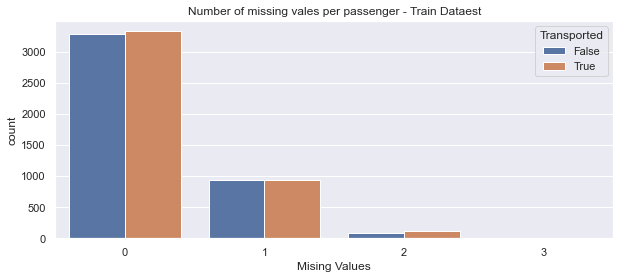

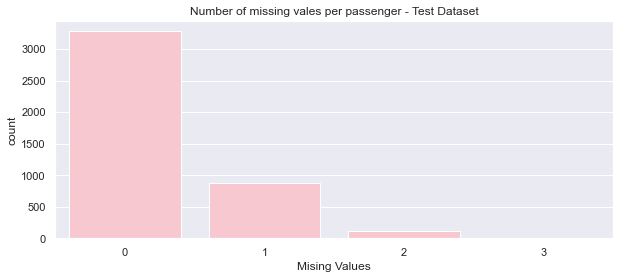

In [9]:
train['Mising Values']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Mising Values', hue='Transported')
plt.title('Number of missing vales per passenger - Train Dataest')
plt.show()

test['Mising Values']=test.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=test, x='Mising Values', color='Pink')
plt.title('Number of missing vales per passenger - Test Dataset')
plt.show()

In [10]:
number_of_rows_train = train.isnull().any(axis=1).sum()
total_number_of_null_train = train['Mising Values'].sum()
number_of_rows_test = test.isnull().any(axis=1).sum()
total_number_of_null_test = test['Mising Values'].sum()
print('Training data: ')
print('Rows with at least one missing values: ', number_of_rows_train)
print('Precentage of rows with missing values in the data:', round( (number_of_rows_train/train.shape[0])*100, 2), '%' )
print('Total number of missing values: ', total_number_of_null_train)

print('\nTest data: ')
print('Rows with at least one missing values: ', number_of_rows_test)
print('Precentage of rows with missing values in the data:', round( (number_of_rows_test/test.shape[0])*100, 2), '%' )
print('Total number of missing values: ', total_number_of_null_test)
train.drop('Mising Values', axis=1, inplace=True)
test.drop('Mising Values', axis=1, inplace=True)

Training data: 
Rows with at least one missing values:  2087
Precentage of rows with missing values in the data: 24.01 %
Total number of missing values:  2324

Test data: 
Rows with at least one missing values:  996
Precentage of rows with missing values in the data: 23.29 %
Total number of missing values:  1117


#### Basic statistics of training data

In [11]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


#### Quick view of Train Data

In [12]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [13]:
data = train.copy()
TARGET = 'Transported'
IDs = 'PassengerId'
FEATURES = [col for col in data.columns if col not in [TARGET, IDs] ] # excludes columns: target and IDs

In [14]:
data.describe().T.sort_values(by='std' , ascending = False).style\
    .bar(subset=["max"], color='salmon')\
    .bar(subset=["mean",], color='pink')\
    .bar(subset=["50%",], color='lightgray')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


#### Categorical features

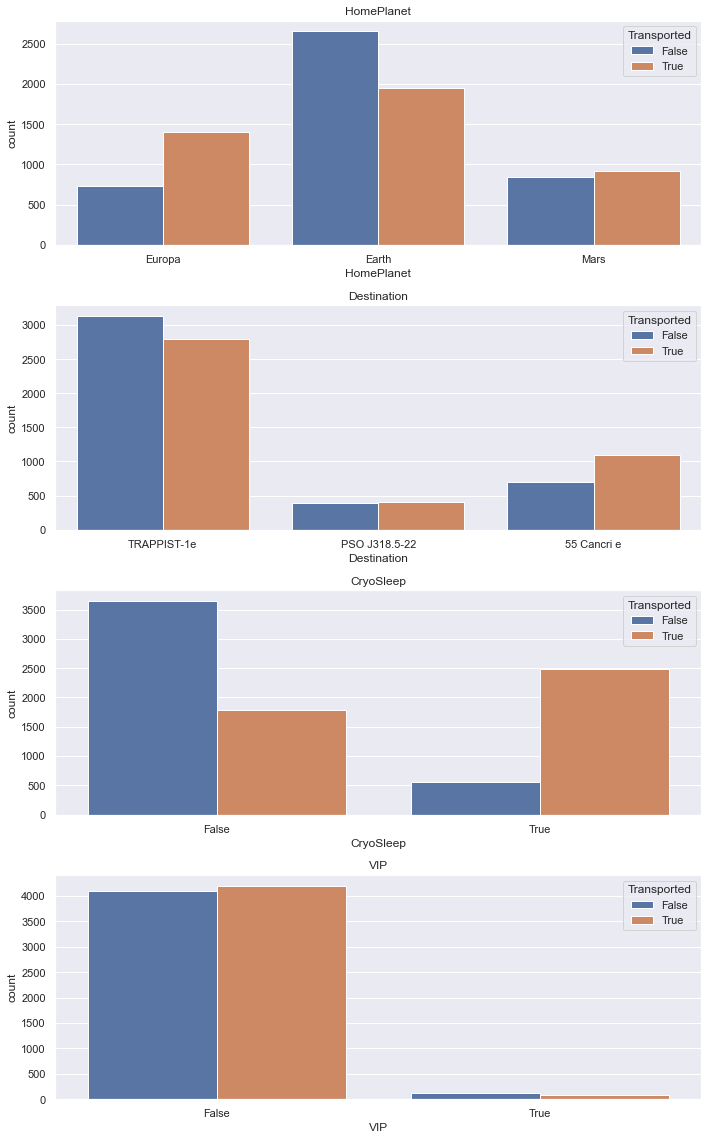

In [15]:
features = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP']

fig=plt.figure(figsize=(10,16))
for i, feature in enumerate(features):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=feature, axes=ax, hue='Transported')
    ax.set_title(feature)
fig.tight_layout()

plt.show()

A few comments on the categorical features shown in the figures above:
- it appears that those traveling from Earth are less likely to reach their destination. Where those departing from Euro have the best chance of doing so.
- in terms of destinations, those going on '55 Cancri e' are more likely to have an uninterrupted journey as opposed to passengers traveling on 'TRAPPIST-1e'. For passengers traveling home, the chances of reaching their destination are almost the same as for those who do not get there.
- with regard to CryoSleep, passengers in cryosleep have the best chance of surviving the journey
- VIP passengers do not appear to be a useful feature. The target split is more or less even.

## DATA REVIEW and ITS PREPARATION

### Groups & Group Size

Each PassengerId takes the form gggg_pp where gggg indicates a group the passenger is traveling with and pp is their number within the group.
Let's extract this information to a new column and check how it looks.

In [16]:
train[['group', 'no_in_group']] = train['PassengerId'].str.split("_", expand = True)
test[['group', 'no_in_group']] = test['PassengerId'].str.split("_", expand = True)
display(train[['PassengerId','group', 'no_in_group']].head(2))
n_groups = train['group'].nunique()
no_passangers = train.shape[0]
print (f'There are {n_groups} groups the passenger are traveliing with')
print(f'Total number of passanggers {no_passangers}')

,PassengerId,group,no_in_group
0,0001_01,0001,01
1,0002_01,0002,01


There are 6217 groups the passenger are traveliing with
Total number of passanggers 8693


In [17]:
group_sizes = train.groupby(['group']).size().reset_index(name = "group_size")
df = group_sizes.groupby(['group_size']).size().reset_index(name='count')
df['%'] = ((df['count'] / df['count'].sum()) *100).round(2)
display(df.style.bar(subset=["count"], color='pink'))

,group_size,count,%
0,1,4805,77.290000
1,2,841,13.530000
2,3,340,5.470000
3,4,103,1.660000
4,5,53,0.850000
5,6,29,0.470000
6,7,33,0.530000
7,8,13,0.210000


In [18]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group,no_in_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01


adding **group_sizes** column to the train dataset

In [19]:
train = pd.merge(train, group_sizes, on='group')

adding **group_sizes** column to the train dataset

In [20]:
group_sizes = test.groupby(['group']).size().reset_index(name = "group_size")
test = pd.merge(test, group_sizes, on='group')

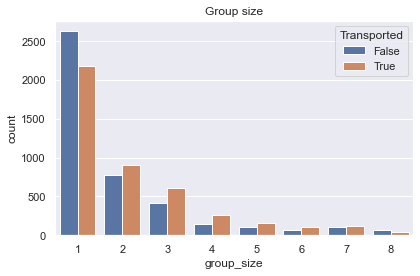

In [21]:
sns.countplot(data=train, x='group_size', hue='Transported')
plt.title('Group size')
plt.tight_layout()

It looks that group people traveling in a group have more chances to get to the destination.

## Question: drop all missing values or not? Yesss you have to :[

### CryoSleep
The highest number of missing values is in the **CryoSleep** column. The column indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins

In [22]:
df = pd.DataFrame(train.groupby('CryoSleep').size(), columns=['count']).reset_index()
df['%'] = ((df['count'] / df['count'].sum()) * 100).round(2)
df.sort_values(by=['count'])

,CryoSleep,count,%
1,True,3037,35.83
0,False,5439,64.17


In [23]:
print('Number of passengers using cryosleep in the Train dataset', list(train['CryoSleep'].value_counts())[1])
print('Number of passengers using cryosleep in the Test dataset', list(test['CryoSleep'].value_counts())[1])

Number of passengers using cryosleep in the Train dataset 3037
Number of passengers using cryosleep in the Test dataset 1544


In [24]:
df = train['CryoSleep'].value_counts().to_frame().reset_index()
df.columns = ['CryoSleep', 'Count']
df.loc[len(df.index)] = ['NULL', train['CryoSleep'].isna().sum()]
df

,CryoSleep,Count
0,False,5439
1,True,3037
2,NULL,217


#### Selecting passengeres with CryoSleep

In [25]:
cyro_true = train[train['CryoSleep'] == True]

dataset = cyro_true.copy()
data_review = pd.DataFrame(columns = ['Column','Data Type','Misssing Values', 'Missing Values [%]', 'Sum Unique Val'])

for index, column in enumerate(dataset.columns):
    data_type = dataset.dtypes[column]
    missing_value = dataset[column].isnull().sum()
    percentage = round((missing_value/len(dataset))* 100,1) if (missing_value/len(dataset))* 100 else 0
    unique_val = len(dataset[column].unique())
    data_review.loc[index] = [column, data_type, missing_value,percentage,unique_val]
    
data_review = data_review.sort_values(by=['Missing Values [%]'], ascending=False)
data_review.style\
        .bar(subset=["Misssing Values"], color='pink')\
        .bar(subset=["Sum Unique Val"], color='pink')\

,Column,Data Type,Misssing Values,Missing Values [%],Sum Unique Val
9,ShoppingMall,float64,96,3.200000,2
3,Cabin,object,84,2.800000,2438
5,Age,float64,82,2.700000,79
6,VIP,object,75,2.500000,3
1,HomePlanet,object,75,2.500000,4
8,FoodCourt,float64,70,2.300000,2
7,RoomService,float64,68,2.200000,2
10,Spa,float64,65,2.100000,2
11,VRDeck,float64,62,2.000000,2
12,Name,object,62,2.000000,2974


In [26]:
dataset = cyro_true[['HomePlanet', 'CryoSleep', 'Destination','VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]

for column in dataset.columns:
    df = dataset[column].value_counts().to_frame().reset_index()
    df.columns = [column, 'Count']
    display(df)

,HomePlanet,Count
0,Earth,1382
1,Europa,911
2,Mars,669


,CryoSleep,Count
0,True,3037


,Destination,Count
0,TRAPPIST-1e,1867
1,55 Cancri e,739
2,PSO J318.5-22,383


,VIP,Count
0,False,2941
1,True,21


,RoomService,Count
0,0.0,2969


,FoodCourt,Count
0,0.0,2967


,ShoppingMall,Count
0,0.0,2941


,Spa,Count
0,0.0,2972


,VRDeck,Count
0,0.0,2975


As shown above, passengers traveling in cryosleep do not pay for  RoomService, FoodCourt, ShoppingMall, Spa & VRDeck. So the null values in those columns we can replace with 0 for them.

In [27]:
zeroes = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for column in zeroes:
    train.loc[(train['CryoSleep'] == True) & (train[column].isnull()), column] = 0
    test.loc[(test['CryoSleep'] == True) & (test[column].isnull()), column] = 0

In [28]:
print('We have still passengers with null values in the CryoSleep column: ', train['CryoSleep'].isnull().sum())

We have still passengers with null values in the CryoSleep column:  217


### CryoSleep & Group

Perhaps when people travel in a group, all members are in cryosleep?

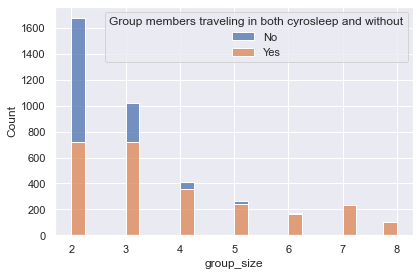

In [29]:
c_group=train.groupby(['group','CryoSleep']).size().unstack().fillna(0).reset_index()
df = train[['group','group_size']]
c_group = c_group.merge(df, on='group')
c_group.loc[c_group[False] > 1,  False]  = 1
c_group.loc[c_group[True] > 1,  True]  = 1
groups_bigger_than_one = c_group.loc[c_group['group_size'] > 1]
groups_bigger_than_one['Group members traveling in both cyrosleep and without'] = np.where((groups_bigger_than_one[True] + groups_bigger_than_one[False]) ==1, 'No', 'Yes')

sns.histplot(data=groups_bigger_than_one, x="group_size", hue="Group members traveling in both cyrosleep and without", multiple="stack")

plt.tight_layout()

This is not helpful and we cannot use it to fill in the null values in CryoSleep

In [30]:
train['CryoSleep'].isnull().sum()

217

### Expenses

**Expenses & CryoSleep** We can assume that people who have no expenses travel in cryptosleep. And those who have any expenses travel without cryosleep.

In [31]:
expenses=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# train dataset
train.loc[(train['CryoSleep'].isnull()) & (train[features].sum(axis=1) == 0), 'CryoSleep'] = True
test.loc[(test['CryoSleep'].isnull()) & (test[features].sum(axis=1) == 0), 'CryoSleep'] = True

train.loc[(train['CryoSleep'].isnull()) & (train[features].sum(axis=1) != 0), 'CryoSleep'] = False
test.loc[(test['CryoSleep'].isnull()) & (test[features].sum(axis=1) != 0), 'CryoSleep'] = False

In [32]:
train['CryoSleep'].isnull().sum()

0

Number of null values in expenses features

In [33]:
data ={ 'expenses': ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
        'null-val count': [train[feature].isnull().sum() for feature in expenses]
      }
df = pd.DataFrame(data)
df

,expenses,null-val count
0,RoomService,113
1,FoodCourt,113
2,ShoppingMall,112
3,Spa,118
4,VRDeck,126


Let's check if there are people in expenses in only one of the features 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' that do not have any null value.

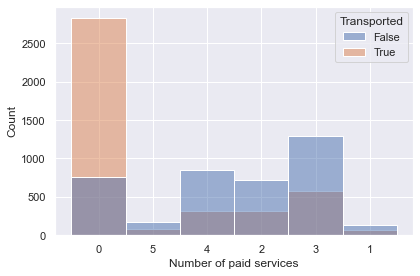

In [34]:
df = train[expenses + ['Transported']] # selecting only relevant features
df = df.dropna() # droping null values


for feature in expenses:
    df[feature] = np.where(df[feature] > 0, 1, 0)

df['Number of paid services'] = (df[expenses].sum(axis=1)).astype('string')

sns.histplot(df, x='Number of paid services', hue='Transported')
plt.tight_layout()

There seem to be people who travel not in the cyrosleep and only spend money on one service. It also appears that those with no expenses are more likely to arrive safely at their destination.  

### Dealing with missing values in numerical attributes, including "Age"

The only option left in this case is to fill in the missing values. We decide that the best approach might be a sklearn class called KNNImputer. This class finds the n most similar rows to the one with the missing value and fills it with the averege value. In addition, it can fill in more than one null value per line, and it can only work with numeric values.  

#### training dataset

In [35]:
features = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
df = train[features].values
print('Missing values in the training dataset\n', train[features].isnull().sum())

imputer = KNNImputer(n_neighbors=2, weights="uniform") # we decided to go with n_neighbors=2 - most similar rows to the one with the missing value and fills it with the averege value. In addition
df = imputer.fit_transform(df) # using KNNImputer to replace null values
df = pd.DataFrame(df, columns= features)

# adding updated features to the training dataset
for feature in features:
    train[feature] = df[feature]

print('Checking if all null values are updated\n', train[features].isnull().sum())

Missing values in the training dataset
 Age             179
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
RoomService     113
dtype: int64
Checking if all null values are updated
 Age             0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
RoomService     0
dtype: int64


#### testing dataset

In [36]:
df = test[features].values
print('Missing values in the testing dataset\n', test[features].isnull().sum())

imputer = KNNImputer(n_neighbors=2, weights="uniform") 
df = imputer.fit_transform(df) 
df = pd.DataFrame(df, columns= features)

for feature in features:
    test[feature] = df[feature]

print('Checking if all null values are updated\n', test[features].isnull().sum())

Missing values in the testing dataset
 Age             91
FoodCourt       67
ShoppingMall    63
Spa             59
VRDeck          51
RoomService     57
dtype: int64
Checking if all null values are updated
 Age             0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
RoomService     0
dtype: int64


### HomePlanet & Group

In [37]:
hm_group=train.groupby(['group','HomePlanet']).size().unstack().fillna(0)
display(hm_group.head(3))
hm_group['Unique HomePlanet per group'] = (hm_group>0).sum(axis=1) # this converts 0 to False and 1 to True then sums up in each row True values equivalent to number of unique home planets
display(hm_group.head(3))
print('Unique HomePlanet per group: ', hm_group['Unique HomePlanet per group'].unique())

HomePlanet,Earth,Europa,Mars
group,,,
0001,0.0,1.0,0.0
0002,1.0,0.0,0.0
0003,0.0,2.0,0.0


HomePlanet,Earth,Europa,Mars,Unique HomePlanet per group
group,,,,
0001,0.0,1.0,0.0,1
0002,1.0,0.0,0.0,1
0003,0.0,2.0,0.0,1


Unique HomePlanet per group:  [1]


In [38]:
df = hm_group[hm_group['Unique HomePlanet per group'] > 1]
print('Number of groups in which members departed from more than one planet: ', df.shape[0])

Number of groups in which members departed from more than one planet:  0


It looks like members of the same group always travel from the same home planet. This means that we can fill in the missing values according to the group, in groups with more than one member. 

In [39]:
print('The total number of passengers with missing information about the home planet', train['HomePlanet'].isnull().sum())

df_null = train[(train['group_size'] > 1) & train['HomePlanet'].isnull()]
df_null = df_null[['group','HomePlanet', 'PassengerId']]
display(df_null.head(2))
print('Number of passengers traveling in a group with missing information about the home planet',df_null.shape[0])

not_null = train[(train['group_size'] > 1) & train['HomePlanet'].notnull()]
not_null = not_null[['group', 'HomePlanet']].drop_duplicates()
display(not_null.head(2))


The total number of passengers with missing information about the home planet 201


,group,HomePlanet,PassengerId
59,0064,NaN,0064_02
113,0119,NaN,0119_01


Number of passengers traveling in a group with missing information about the home planet 92


,group,HomePlanet
2,0003,Europa
6,0006,Earth


In [40]:
not_null.index = not_null['group']
not_null.drop('group', axis=1, inplace=True)
not_null.loc['0003', 'HomePlanet']

'Europa'

In [41]:
def fill_nan(row):
    if pd.isna(row['HomePlanet']) and row['group'] in list(not_null.index):
        return not_null.loc[row['group'], 'HomePlanet']
    else:
        return row['HomePlanet']
train['HomePlanet'] = train.apply(fill_nan, axis=1)
print('The total number of passengers with missing information about the home planet', train['HomePlanet'].isnull().sum())

The total number of passengers with missing information about the home planet 111


Filling the same way missing values in the test dataset

In [42]:
print('Number of passengers traveling in a group with missing information about the home planet in the test dataset',test['HomePlanet'].isnull().sum())
not_null = test[(test['group_size'] > 1) & test['HomePlanet'].notnull()]
not_null = not_null[['group', 'HomePlanet']].drop_duplicates()
not_null.index = not_null['group']
not_null.drop('group', axis=1, inplace=True)
def fill_nan(row):
    if pd.isna(row['HomePlanet']) and row['group'] in list(not_null.index):
        return not_null.loc[row['group'], 'HomePlanet']
    else:
        return row['HomePlanet']
test['HomePlanet'] = test.apply(fill_nan, axis=1)
print('And after filling the missing values: ',test['HomePlanet'].isnull().sum())

Number of passengers traveling in a group with missing information about the home planet in the test dataset 87
And after filling the missing values:  46


### HomePlanet

In [43]:
print('Number of missing values in the train dataset: ', train['HomePlanet'].isnull().sum())

Number of missing values in the train dataset:  111


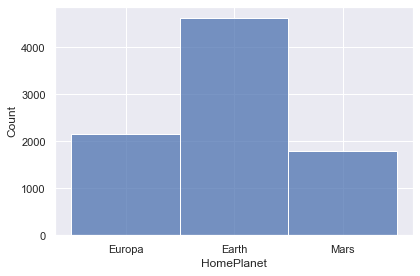

In [44]:
sns.histplot(data=train, x=train["HomePlanet"])
plt.tight_layout()

In [45]:
df = pd.DataFrame(train.groupby('HomePlanet').size(), columns=['count']).reset_index()
df['%'] = ((df['count'] / df['count'].sum()) * 100).round(2)
df.sort_values(by=['count'])

,HomePlanet,count,%
2,Mars,1787,20.82
1,Europa,2161,25.18
0,Earth,4634,54.00


Knowing that nearly 54% of people travel from Earth, we can set it for all null values in the HomePlanet column for both train and test datasets.

In [46]:
train.loc[(train['HomePlanet'].isna()), 'HomePlanet']='Earth'
test.loc[(test['HomePlanet'].isna()), 'HomePlanet']='Earth'

### Destination & Group

In [47]:
d_group=train.groupby(['group','Destination']).size().unstack().fillna(0)
d_group['Unique Destination per group'] = (d_group>0).sum(axis=1) # this converts 0 to False and 1 to True then sums up in each row True values equivalent to number of unique home planets
display(d_group.head(3))
print('Unique Destination per group: ', d_group['Unique Destination per group'].unique())

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,Unique Destination per group
group,,,,
0001,0.0,0.0,1.0,1
0002,0.0,0.0,1.0,1
0003,0.0,0.0,2.0,1


Unique Destination per group:  [1 2 3]


People in groups do not always travel to the same destination.

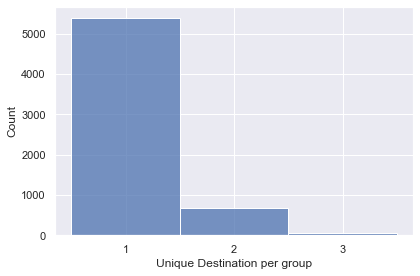

In [48]:
sns.histplot(data=d_group, x=d_group["Unique Destination per group"].astype("S"))
plt.tight_layout()

### Destination

In [49]:
print('Number of missing values in the train dataset: ', train['Destination'].isnull().sum())


Number of missing values in the train dataset:  182


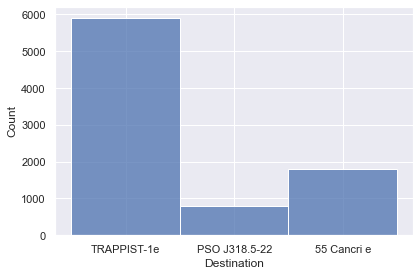

In [50]:
sns.histplot(data=d_group, x=train["Destination"])
plt.tight_layout()

In [51]:
df = pd.DataFrame(train.groupby('Destination').size(), columns=['count']).reset_index()
df['%'] = ((df['count'] / df['count'].sum()) * 100).round(2)
df.sort_values(by=['count'])

,Destination,count,%
1,PSO J318.5-22,796,9.35
0,55 Cancri e,1800,21.15
2,TRAPPIST-1e,5915,69.50


Knowing that nearly 70% of people travel to TRAPPIST-1e, we can set it for all null values in the destination column for both train and test datasets.

In [52]:
train.loc[(train['Destination'].isna()), 'Destination']='TRAPPIST-1e'
test.loc[(test['Destination'].isna()), 'Destination']='TRAPPIST-1e'

### Name

In [53]:
print('Missing names in the training dataset: ', train['Name'].isnull().sum())
display(train.loc[train['Name'].isnull()].head(3))
display(train.head(5))

Missing names in the training dataset:  200


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group,no_in_group,group_size
27,0022_01,Mars,False,D/0/P,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,0.0,NaN,False,0022,01,1
58,0064_01,Mars,True,F/14/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,0064,01,2
65,0069_01,Earth,False,F/16/S,TRAPPIST-1e,42.0,False,887.0,0.0,9.0,6.0,0.0,NaN,True,0069,01,1


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group,no_in_group,group_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,1


We believe that names are not important for running predictive models and we will not use this information. 

### Cabin
 - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [54]:
print('Missing data in the training dataset: ', train['Cabin'].isnull().sum())

Missing data in the training dataset:  199


As we can see, the cabin number consists of 3 pieces of information. First, we create 3 new columns for this information (deck, num, and side), and we will try to find and detect any pattern that could help us to fill in the missing data.

In [55]:
print('Number of unique cabins in the training dataset: ', len(train['Cabin'].unique()))

Number of unique cabins in the training dataset:  6561


In [56]:
train[['deck', 'num','side']] = train['Cabin'].str.split("/", expand = True)
test[['deck', 'num','side']] = test['Cabin'].str.split("/", expand = True)

Number of **decks** - cruise ships tend to be numbered going from the bottom up. It begins with Deck 1 and can go up [source](https://www.cruisehive.com/what-is-on-the-lowest-deck-on-a-ship/78515)

In [57]:
df = train['deck'].value_counts().reset_index(name='count').sort_values(by=['index'], ascending=False)
df['%'] = ((df['count'] / df['count'].sum()) *100).round(2)
df.columns = ['deck', 'count', 'count %']
df.style.bar(subset=["count %"], color='pink')

,deck,count,count %
7,T,5,0.060000
1,G,2559,30.130000
0,F,2794,32.890000
2,E,876,10.310000
5,D,478,5.630000
4,C,747,8.790000
3,B,779,9.170000
6,A,256,3.010000


#### Deck vs Trasported

count
deck Transported       
T    True             1
     False            4
G    True          1321
     False         1238
F    True          1229
     False         1565
E    True           313
     False          563
D    True           207
     False          271
C    True           508
     False          239
B    True           572
     False          207
A    True           127
     False          129

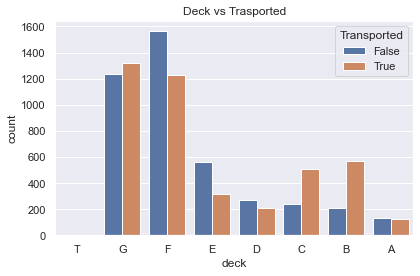

In [58]:
# multiIndex and sorting by index 
df = train.groupby(['deck', 'Transported'])['Transported'].count().to_frame(name='count').sort_index(ascending=False)
display(df)
sns.barplot(x="deck", y="count", hue="Transported", data=df.reset_index()) # moving multindex to columns; this way we can use 'Transported' as hue
plt.title('Deck vs Trasported')
plt.tight_layout()

The largest number of people travel on decks G and F, around 66% of passengers. Passengers traveling on B, C & G decks have the highest chances of reaching their destination - in that order.

#### Deck vs CryoSleep

count
deck CryoSleep       
T    True           1
     False          4
G    True        1413
     False       1146
F    True         618
     False       2176
E    True         188
     False        688
D    True         114
     False        364
C    True         317
     False        430
B    True         438
     False        341
A    True          74
     False        182

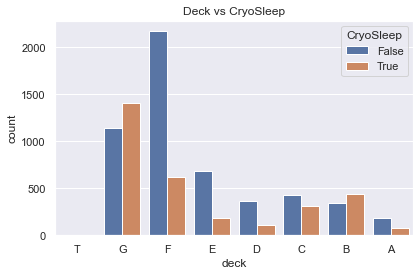

In [59]:
df = train.groupby(['deck', 'CryoSleep'])['CryoSleep'].count().to_frame(name='count').sort_index(ascending=False)
display(df)
sns.barplot(x="deck", y="count", hue="CryoSleep", data=df.reset_index())
plt.title('Deck vs CryoSleep')
plt.tight_layout()

The majority of passengers traveling in cryosleep, as we can see, are on B and G decks. These are the decks where more people arrive at their destination. In addition, we already know that people in cryosleep are more likely to complete their journey safely.

**Do people in the same group travel on the same deck?**

In [60]:
df = train.loc[(train['group_size'] > 1) & (train['deck'].notnull()) ]
display(df.groupby(['group', 'deck']).size().unstack().head(5))
print('No, there are groups that travel on different decks.')

deck,A,B,C,D,E,F,G
group,,,,,,,
0003,2.0,NaN,NaN,NaN,NaN,NaN,NaN
0006,NaN,NaN,NaN,NaN,NaN,1.0,1.0
0008,NaN,3.0,NaN,NaN,NaN,NaN,NaN
0017,NaN,NaN,NaN,NaN,NaN,1.0,1.0
0020,NaN,NaN,NaN,NaN,6.0,NaN,NaN


No, there are groups that travel on different decks.


**Do people with the same surname in a group travel on the same deck?**

,A,B,C,D,E,F,G,T,Fmiliy on the same deck
0001,0,1,0,0,0,0,0,0,Yes


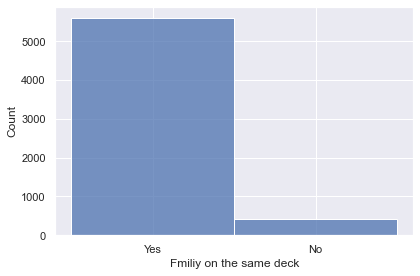

In [61]:
df = train.loc[(train['Name'].notnull())&(train['deck'].notnull())]
df['Name'] = df['Name'].str.strip() # removing leading and trailing characters
df[['First Name', 'Surname']] = df['Name'].str.split(" ", expand = True) # splitting names into 2 new columns

decks = sorted(list(train[train['deck'].notnull()]['deck'].unique()))
data = { deck:[0 for x in range(len(list(df['group'].unique())))] for deck in decks}
data = pd.DataFrame(data, index=list(df['group'].unique()))

def deck_group(row):
    data.loc[row['group'], row['deck']] = 1

df.apply(deck_group, axis=1)
data['Fmiliy on the same deck'] = np.where(data[decks].sum(axis=1) >1, 'No', 'Yes')
display(data.head(1))

sns.histplot(data=data, x=data['Fmiliy on the same deck'])
plt.tight_layout()

In most cases, people traveling with their families are on the same deck. However, there are instances when they travel on different decks.

#### Side

#### Deck vs Trasported

count
side Transported       
S    True          2380
     False         1908
P    True          1898
     False         2308

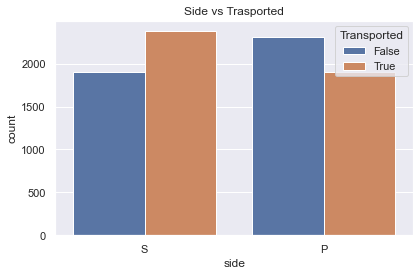

In [62]:
# multiIndex and sorting by index 
df = train.groupby(['side', 'Transported'])['Transported'].count().to_frame(name='count').sort_index(ascending=False)
display(df)
sns.barplot(x="side", y="count", hue="Transported", data=df.reset_index()) # moving multindex to columns; this way we can use 'Transported' as hue
plt.title('Side vs Trasported')
plt.tight_layout()

#### Side vs CryoSleep

count
side CryoSleep       
S    True        1630
     False       2658
P    True        1533
     False       2673

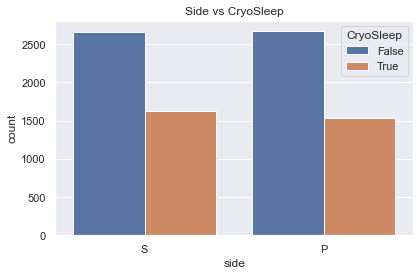

In [63]:
df = train.groupby(['side', 'CryoSleep'])['CryoSleep'].count().to_frame(name='count').sort_index(ascending=False)
display(df)
sns.barplot(x="side", y="count", hue="CryoSleep", data=df.reset_index())
plt.title('Side vs CryoSleep')
plt.tight_layout()

CryoSleep is evenly distributed between both sides.

#### Do people in the same group travel on the same side?

In [64]:
df = train.loc[(train['group_size'] > 1) & (train['side'].notnull()) ]
df = df.groupby(['group', 'side']).size().unstack().fillna(0)
df['P'] = np.where(df['P'] > 1, 1,0)
df['S'] = np.where(df['S'] > 1, 1,0)
df['Group travels on the same side'] = np.where(df.sum(axis=1) >1, 'No', 'Yes')
print(df['Group travels on the same side'].unique())

['Yes']


We have a dependency between group size bigger than one and side - people traveling in a group always are located on the same side of the ship. Knowing this, we can fill in missing based on this rule.

In [65]:
print('Number of null values in the training dataset before: ',train['side'].isnull().sum())

Number of null values in the training dataset before:  199


In [66]:
# TRAINING DATASET
# selecting groups outwith null side
train.index = train['PassengerId']
group_notnull = train.loc[(train['side'].notnull()) & (train['group_size'] > 1)][['group', 'side']]

# selecting group ids with null side
passenger_id_null = train.loc[(train['side'].isnull()) & (train['group_size'] > 1)][['group','PassengerId']]

# filling in missing data
def fill_nan(row):
    group = row['group']
    PassengerId = row['PassengerId']
    side = train.loc[ (train['group'] == group) & train['side'].notnull() ]['side'].unique()[0] # returns P or S
    train.loc[row['PassengerId'], 'side'] = side
    
passenger_id_null.apply(fill_nan, axis=1)
print('Number of null values in the training dataset after: ',train['side'].isnull().sum())

Number of null values in the training dataset after:  99


In [67]:
# TESTING DATASET
# selecting groups outwith null side
train.index = train['PassengerId']
group_notnull = train.loc[(train['side'].notnull()) & (train['group_size'] > 1)][['group', 'side']]

# selecting group ids with null side
passenger_id_null = train.loc[(train['side'].isnull()) & (train['group_size'] > 1)][['group','PassengerId']]

# filling in missing data
def fill_nan(row):
    group = row['group']
    PassengerId = row['PassengerId']
    side = train.loc[ (train['group'] == group) & train['side'].notnull() ]['side'].unique()[0] # returns P or S
    train.loc[row['PassengerId'], 'side'] = side
    
passenger_id_null.apply(fill_nan, axis=1)
print('Number of null values in the training dataset after: ',train['side'].isnull().sum())

Number of null values in the training dataset after:  99


In [68]:
# TESTING DATASET
print('Number of null values in the training dataset before: ', test['side'].isnull().sum())
# selecting groups outwith null side
test.index = test['PassengerId']
group_notnull = test.loc[(test['side'].notnull()) & (test['group_size'] > 1)][['group', 'side']]

# selecting group ids with null side
passenger_id_null = test.loc[(test['side'].isnull()) & (test['group_size'] > 1)][['group','PassengerId']]

# filling in missing data
def fill_nan(row):
    group = row['group']
    PassengerId = row['PassengerId']
    try:
        side = test.loc[ (test['group'] == group) & test['side'].notnull() ]['side'].unique()[0] # returns P or S
        test.loc[row['PassengerId'], 'side'] = side
    except:
        pass
    
passenger_id_null.apply(fill_nan, axis=1)
print('Number of null values in the testing dataset after: ',test['side'].isnull().sum())

Number of null values in the training dataset before:  100
Number of null values in the testing dataset after:  63


We will fill in the remaining missing values for the cabin sides using KNNInputer after replacing the categorical values with numbers.

Also, we decided to proceed with the same strategy when dealing with these categorical data: **deck & VIP**

**Name, group** and **num** columns, in our opinion, are irrelevant and we will not use them in the ML models

## Categorical to numerical

#### CryoSleep

In [69]:
def CryoSleep(row):
    if row['CryoSleep'] == True:
        return 1
    else:
        return 0

train['CryoSleep'] = train.apply(CryoSleep, axis = 1)
test['CryoSleep'] = test.apply(CryoSleep, axis = 1)

#### Convertic decks to numeric values

In [70]:
df = train.loc[train['deck'].notnull()] 
code = list(df['deck'].unique())
code.sort()
code_dic = { code[i]:i for i in range(len(code))}
code_dic

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}

In [71]:
def deck(row):
    if isinstance(row['deck'], float):
        return np.nan
    else:
        return code_dic[row['deck']]

train['deck'] = train.apply(deck, axis = 1)
test['deck'] = test.apply(deck, axis = 1)
test['deck'].unique()

array([ 6.,  5.,  2.,  1.,  3.,  4., nan,  0.,  7.])

#### Cabin side

Convertic sides to numeric values:
- S => 0
- P => 1

In [72]:
def side(row):
    if isinstance(row['side'], float):
        return np.nan
    else:
        if row['side'] == 'S':
            return 0
        else:
            return 1

train['side'] = train.apply(side, axis = 1)
test['side'] = test.apply(side, axis = 1)
print('train', train['side'].unique())
print('test', test['side'].unique())

train [ 1.  0. nan]
test [ 0.  1. nan]


#### VIP
Converting to numeric values:
- False => 0
- True => 1

In [73]:
def VIP(row):
    if isinstance(row['VIP'], float):
        return np.nan
    else:
        if row['VIP'] == True:
            return 1
        else:
            return 0

train['VIP'] = train.apply(VIP, axis = 1)
test['VIP'] = test.apply(VIP, axis = 1)
print('train', train['VIP'].unique())
print('test', test['VIP'].unique())

train [ 0.  1. nan]
test [ 0. nan  1.]


#### HomePlanet

Converting to numeric values:
- Earth     0
- Europa    1
- Mars      2

In [74]:
code = list(train['HomePlanet'].unique())
code.sort()
code_dic = { code[i]:i for i in range(len(code))}
code_dic

{'Earth': 0, 'Europa': 1, 'Mars': 2}

In [75]:
def HomePlanet(row):
    return code_dic[row['HomePlanet']]

train['HomePlanet'] = train.apply(HomePlanet, axis = 1)
test['HomePlanet'] = test.apply(HomePlanet, axis = 1)

#### Destination

Converting to numeric values:
- 55 Cancri e ------- 0
- PSO J318.5-22 ----- 1
- TRAPPIST-1e ------- 2

In [76]:
code = list(train['Destination'].unique())
code.sort()
code_dic = { code[i]:i for i in range(len(code))}
code_dic

{'55 Cancri e': 0, 'PSO J318.5-22': 1, 'TRAPPIST-1e': 2}

In [77]:
def Destination(row):
    return code_dic[row['Destination']]

train['Destination'] = train.apply(Destination, axis = 1)
test['Destination'] = test.apply(Destination, axis = 1)

#### Transported

Converting to numeric values:
- False => 0
- True => 1


In [78]:
def Transported(row):
    if row['Transported'] == True:
        return 1
    else:
        return 0

train['Transported'] = train.apply(Transported, axis = 1)

### Selecting feature set

#### Pearson correlation coefficient (PCC)
- [source](https://stackabuse.com/bytes/calculate-correlation-of-dataframe-featurescolumns-with-pandas/)
- [Spearman Rank Correlation](https://stackabuse.com/calculating-spearmans-rank-correlation-coefficient-in-python-with-pandas/)

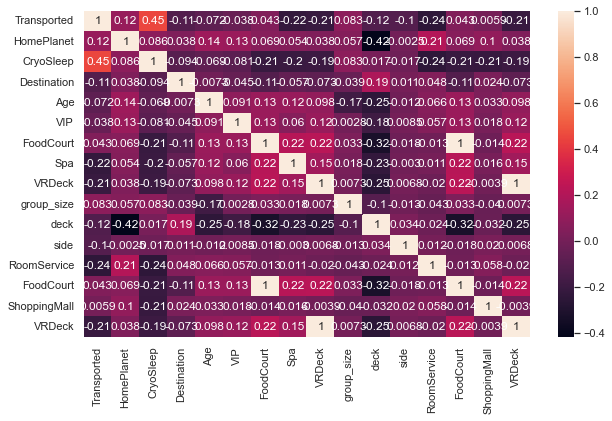

In [79]:
features = train[['Transported','HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'FoodCourt', 'Spa', 'VRDeck','group_size', 'deck', 'side','RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck']]
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(features.corr(), ax=ax, annot=True)
plt.show()

#### Pearson, Spearman and Kendall Rank Coefficients to Target Variable

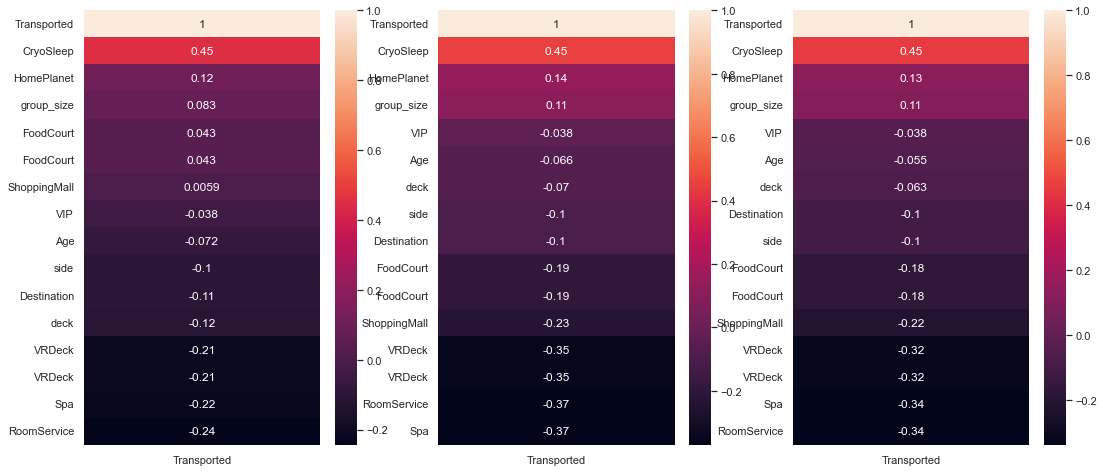

In [80]:
fig, ax = plt.subplots(1,3, figsize=(18, 8))

corr1 = features.corr('pearson')[['Transported']].sort_values(by='Transported', ascending=False)
corr2 = features.corr('spearman')[['Transported']].sort_values(by='Transported', ascending=False)
corr3 = features.corr('kendall')[['Transported']].sort_values(by='Transported', ascending=False)

sns.heatmap(corr1, ax=ax[0], annot=True)
sns.heatmap(corr2, ax=ax[1], annot=True)
sns.heatmap(corr3, ax=ax[2], annot=True)

plt.show()

In [81]:
features = train[['Transported','HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'FoodCourt', 'Spa', 'VRDeck','group_size', 'deck', 'side','RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck']]

In [82]:
# initializing new data frame that will be displayed in the table
dataset = train.copy()
data_review = pd.DataFrame(columns = ['Column','Data Type','Misssing Values', 'Missing Values [%]', 'Sum Unique Val'])

# looping via columns and extracting needed information
for index, column in enumerate(dataset.columns):
    data_type = dataset.dtypes[column]
    missing_value = dataset[column].isnull().sum()
    percentage = round((missing_value/len(dataset))* 100,1) if (missing_value/len(dataset))* 100 else 0
    unique_val = len(dataset[column].unique())
    data_review.loc[index] = [column, data_type, missing_value,percentage,unique_val]
    
pd.set_option("max_rows", None) # all rows are shown when printing  

    
data_review = data_review.sort_values(by=['Missing Values [%]'], ascending=False)
data_review.style\
        .bar(subset=["Misssing Values"], color='pink')\
        .bar(subset=["Sum Unique Val"], color='pink')

,Column,Data Type,Misssing Values,Missing Values [%],Sum Unique Val
18,num,object,199,2.300000,1818
3,Cabin,object,199,2.300000,6561
17,deck,float64,199,2.300000,9
6,VIP,float64,203,2.300000,3
12,Name,object,200,2.300000,8474
19,side,float64,99,1.100000,3
11,VRDeck,float64,0,0,1347
16,group_size,int64,0,0,8
15,no_in_group,object,0,0,8
14,group,object,0,0,6217


https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

Useful link for missing values:
- https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python/notebook
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
- https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation
- Impute missing values using KNNImputer or IterativeImputer: https://www.youtube.com/watch?v=m_qKhnaYZlc
- KNNImputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
- https://scikit-learn.org/stable/modules/impute.html  SCIKIT MISSING VALUES